### Wrinkle Detection
#### U-net w. f-1 loss
* https://datalab.snu.ac.kr/datalab-internal/gpu-status/
* warhol2
  * `jupyter lab --ip=147.46.216.82 --NotebookApp.password='sha1:6d8bb616ac21:dc1b7ebffd85cb159379a282c6b49e6121e0ffb1'`
* warhol4 `http://147.46.215.47:8011/`

In [2]:
import torch
print(torch.cuda.device(0))
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())
# print(torch.cuda.memory_allocated())
# print(torch.cuda.memoy_cached())

4
GeForce GTX 1080 Ti
True


In [3]:
import argparse

import os
import csv
import datetime
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import plot_metric
from unet.model import UNet
from unet.dataset import *
from unet.util import *
from unet.train import train
from unet.evaluate import evaluate
from unet.loss import f1_loss, weighted_loss_and_f1_loss

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from torchvision import transforms, datasets

In [4]:
import shutil
DATA = [os.path.splitext(name)[0] for name in os.listdir('../data/competitor/original')]
print(len(DATA))

40


In [5]:
ckpts = {}
logs = {}

face_dict = {
    'eye_left': (0, 575, 220, 603),
    'eye_right': (672, 1247, 220, 603),
    'nose_left': (350, 573, 400, 943),
    'nose_right': (700, 923, 400, 943),
    'mouth': (300, 971, 940, 1195),
    'forehead': (0, 1247, 0, 223),
    'cheek_right': (896, 1247, 576, 1343),
    'cheek_left': (0, 351, 576, 1343),
    'jaw': (350, 925, 1152, 1343),
    'center': (550, 709, 220, 955)
}

In [38]:
# for name in DATA:
#     try: shutil.copy(f'../data/final_data/val/{name}.npy', f'../data/competitor/original/{name}.npy')
#     except: pass
#     try: shutil.copy(f'../data/final_data/test/{name}.npy', f'../data/competitor/original/{name}.npy')
#     except: pass

In [10]:
keys = list(face_dict.keys())
# print(keys)

# for key in keys:
#     d = f'../data/competitor/split_data/{key}'
#     if not os.path.exists(d):
#         os.makedirs(d)
#     for name in DATA:
#         try: shutil.copy(f'../data/split_data/{key}/test/{name}.npy', f'../data/competitor/split_data/{key}/{name}.npy')
#         except: pass
#         try: shutil.copy(f'../data/split_data/{key}/val/{name}.npy', f'../data/competitor/split_data/{key}/{name}.npy')
#         except: pass

In [11]:
for key in face_dict:
    new_ckpt = {}
    new_log = {}
    
    machine = 'warhol1'
    loss = 'f1'
    new_ckpt[loss], new_log[loss] = (f'./checkpoint/{machine}_{key}_{loss} ./log/{machine}_{key}_{loss}'.split())
    
    machine = 'warhol4'
    loss = 'weighted_BCE'
    new_ckpt[loss], new_log[loss] = (f'./checkpoint/{machine}_{key}_{loss} ./log/{machine}_{key}_{loss}'.split())
    
    ckpts[key], logs[key] = new_ckpt, new_log

In [12]:
fn_tonumpy = lambda x: x.to('cpu').detach().numpy().transpose(0, 2, 3, 1)
fn_denorm = lambda x, mean, std: (x * std) + mean
fn_class = lambda x: 1.0 * (x > 0)

def f1_score(y_pred, y_true):
    eps = np.finfo(np.float64).eps

    tp = np.sum(y_true*y_pred)
    tn = np.sum((1-y_true)*(1-y_pred))
    fp = np.sum((1-y_true)*y_pred)
    fn = np.sum(y_true*(1-y_pred))

    p = (tp) / (tp + fp + eps)
    r = (tp) / (tp + fn + eps)
    f1 = 2*p*r / (p + r + eps)
    f1 = np.where(np.isnan(f1), np.zeros_like(f1), f1)
    return tp, tn, fp, fn, f1

def load(ckpt_dir, net, ckpt_name=None):
    if not os.path.exists(ckpt_dir):
        epoch = 0
        print("ckpt_dir : ", ckpt_dir)
        print("ckpt_name : ", ckpt_name)
        print("failed to load model")
        return None

    if ckpt_name == None:
        ckpt_lst = os.listdir(ckpt_dir)
        ckpt_lst.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
        ckpt_name = ckpt_lst[-1]

    dict_model = torch.load('%s/%s' % (ckpt_dir, ckpt_name))

    net.load_state_dict(dict_model['net'])

    return net

def merge_and_evaluate(split_data_dir, orig_data_dir, result_dir, ckpt_dirs, coordinates, h=1344, w=1248, included_parts=[]):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    time = datetime.datetime.today()
    time = time.strftime('%m-%d_%H-%M')
    keys = list(coordinates.keys())

    result_dir = result_dir + time + "/"
    if not os.path.exists(result_dir):
        os.makedirs(os.path.join(result_dir, 'png'))

    orig_data_dir = os.path.join(orig_data_dir)
    sample_data_dir = os.path.join(split_data_dir, keys[0])
    image_list = os.listdir(sample_data_dir)
    image_list = [img_file_name for img_file_name in image_list if img_file_name.endswith(".jpg")]
    image_num = len(image_list)

    pred_result = np.zeros((image_num, 1344, 1248))
    
    f = open(os.path.join(result_dir, 'log.txt'), 'w')
    
    transform = transforms.Compose([Normalization(mean=0.5, std=0.5), ToTensor()])
    
    for key in keys:
        if key not in included_parts and len(included_parts) is not 0:
            continue
        data_key_dir = os.path.join(split_data_dir, key)
        coord = coordinates[key]
        x1, x2, y1, y2 = coord
        ckpt_dir = ckpt_dirs[key]
        net = UNet()
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
        net.to(device)
        print("loading from ", ckpt_dir, "...")
        net = load(ckpt_dir=ckpt_dir, net=net)
        if net is None:
            continue
        dataset_test = Dataset(data_key_dir, transform=transform)
        loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=1)
        
        with torch.no_grad():
            net.eval()
            
            for index, data in enumerate(loader_test):
                label = data['label'].to(device)
                input = data['input'].to(device)
                
                output = net(input)
                # N x H x W x C
                pred = fn_tonumpy(fn_class(output))
                pred_result[index, y1:y2+1, x1:x2+1] = np.logical_or(pred_result[index, y1:y2+1, x1:x2+1],pred[0].squeeze())
        del net
        del dataset_test
        del loader_test
    
#     lable_list = os.listdir(orig_data_dir)
#     lable_list = [label_file_name for label_file_name in lable_list if label_file_name.endswith(".npy")]
#     lable_list = sorted(lable_list)
#     f1_arr = []
#     for i in range(image_num):
#         label = np.load(os.path.join(orig_data_dir, lable_list[i]))
#         tp, tn, fp, fn, f1 = f1_score(pred_result[i], label)
#         print("TEST: BATCH %04d / %04d | F1 SCORE %.4F" %
#                     (i+1, image_num, f1))
#         f.write("TEST: BATCH %04d / %04d | F1 SCORE %.4F\n" %
#                     (i+1, image_num, f1))
#         f1_arr.append(f1)
#         plt.imsave(os.path.join(result_dir, 'png', '%04d_output.png' % i), pred_result[i], cmap='gray')
#         plt.imsave(os.path.join(result_dir, 'png', '%04d_label.png' % i), label, cmap='gray')
#     print("AVERAGE TEST: TOTAL IMAGES : %04d | F1 SCORE %.4F" %
#                     (image_num, np.mean(f1_arr)))
#     f.write("AVERAGE TEST: TOTAL IMAGES : %04d | F1 SCORE %.4F\n" %
#                     (image_num, np.mean(f1_arr)))
    return pred_result
        

In [13]:
ckpt_dirs = {}
(split_data_dir, orig_data_dir, result_dir)  = ("../data/competitor/split_data", "../data/competitor/original", f"../data/competitor/result/")
for key in ckpts:
    ckpt_dirs[key] = ckpts[key]['f1']
f1_pred_result = merge_and_evaluate(split_data_dir, orig_data_dir, result_dir, ckpt_dirs, face_dict)
for key in ckpts:
    ckpt_dirs[key] = ckpts[key]['weighted_BCE']
wbce_pred_result = merge_and_evaluate(split_data_dir, orig_data_dir, result_dir, ckpt_dirs, face_dict)

loading from  ./checkpoint/warhol1_eye_left_f1 ...
loading from  ./checkpoint/warhol1_eye_right_f1 ...
loading from  ./checkpoint/warhol1_nose_left_f1 ...
loading from  ./checkpoint/warhol1_nose_right_f1 ...
loading from  ./checkpoint/warhol1_mouth_f1 ...
loading from  ./checkpoint/warhol1_forehead_f1 ...
loading from  ./checkpoint/warhol1_cheek_right_f1 ...
loading from  ./checkpoint/warhol1_cheek_left_f1 ...
loading from  ./checkpoint/warhol1_jaw_f1 ...
loading from  ./checkpoint/warhol1_center_f1 ...
loading from  ./checkpoint/warhol4_eye_left_weighted_BCE ...
loading from  ./checkpoint/warhol4_eye_right_weighted_BCE ...
loading from  ./checkpoint/warhol4_nose_left_weighted_BCE ...
loading from  ./checkpoint/warhol4_nose_right_weighted_BCE ...
loading from  ./checkpoint/warhol4_mouth_weighted_BCE ...
loading from  ./checkpoint/warhol4_forehead_weighted_BCE ...
loading from  ./checkpoint/warhol4_cheek_right_weighted_BCE ...
loading from  ./checkpoint/warhol4_cheek_left_weighted_BCE .

In [14]:
keys = list(face_dict.keys())
competitor_dir = os.path.join("../data/competitor/morpheus/")
baseline_dir = os.path.join("../data/competitor/baseline/")
orig_data_dir = os.path.join("../data/competitor/original")
sample_data_dir = os.path.join("../data/competitor/split_data/", keys[0])
image_list = os.listdir(sample_data_dir)
image_list = [img_file_name for img_file_name in image_list if img_file_name.endswith(".jpg")]
image_list = sorted(image_list)
image_num = len(image_list)

lable_list = os.listdir(orig_data_dir)
lable_list = [label_file_name for label_file_name in lable_list if label_file_name.endswith(".npy")]
lable_list = sorted(lable_list)

0005_f_45_06_jaw_right_tex


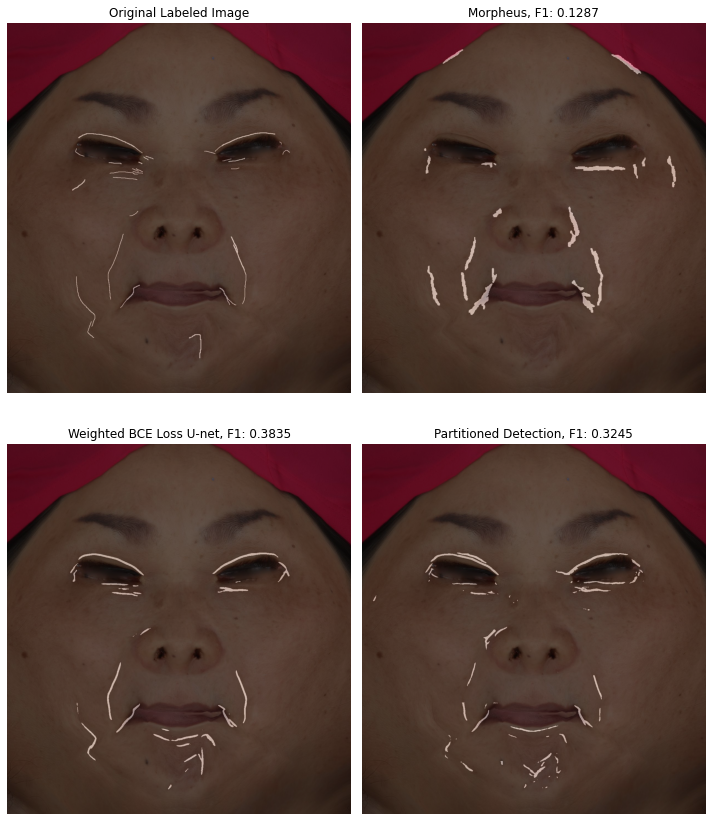

0005_f_45_12_lip_puckerer_tex


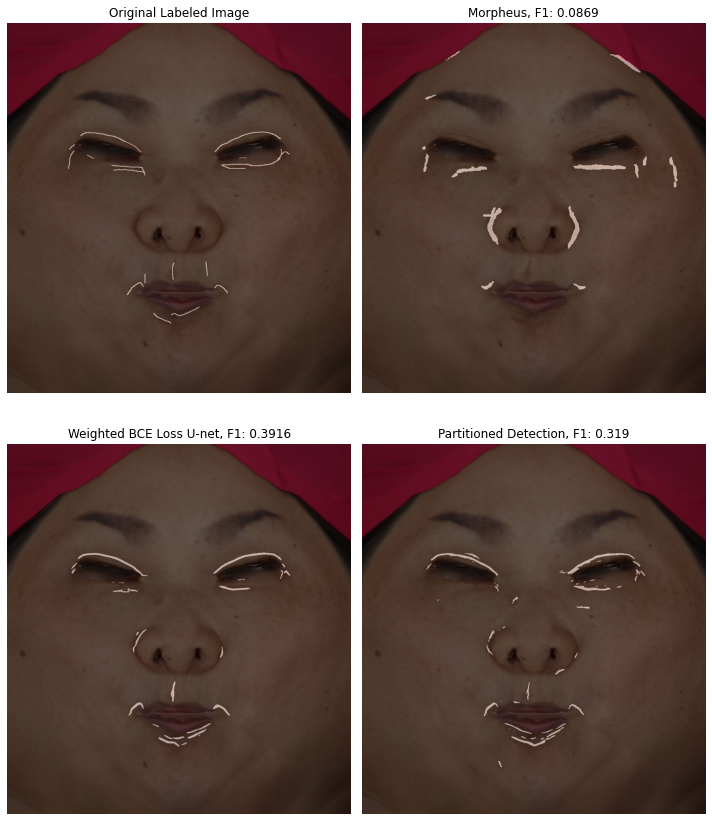

0005_f_45_16_grin_tex


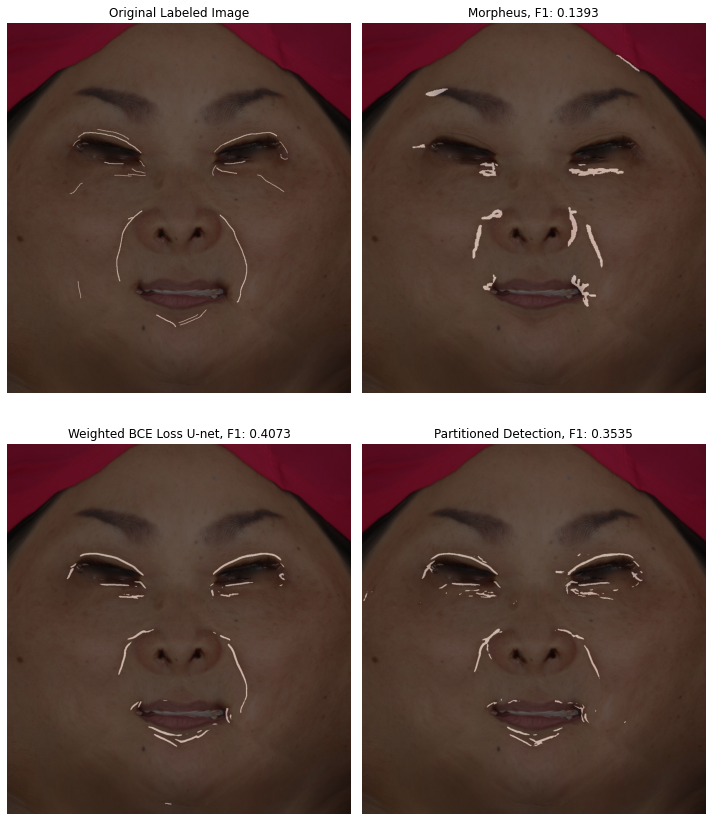

0008_f_25_04_anger_tex


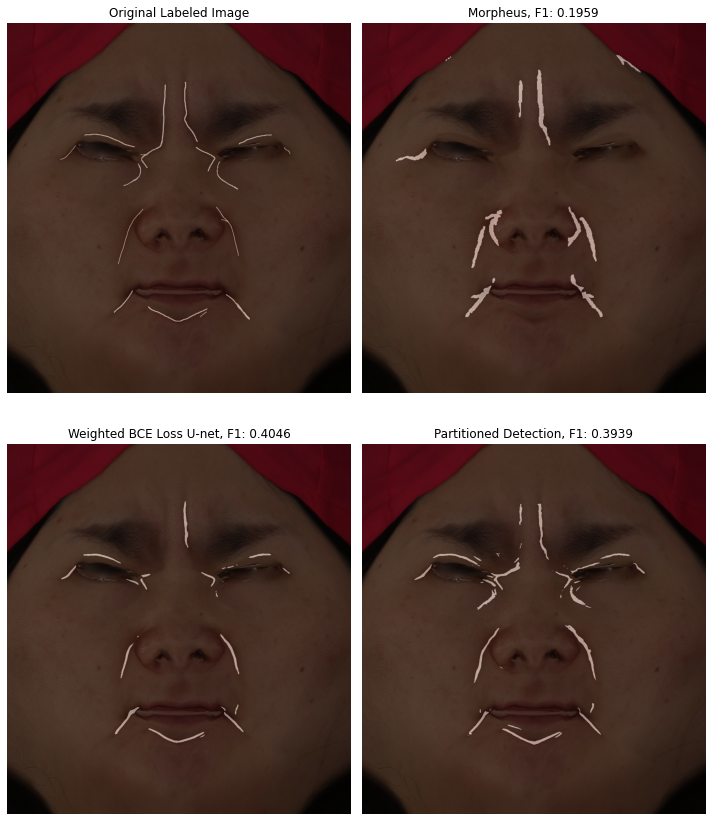

0008_f_25_12_lip_puckerer_tex


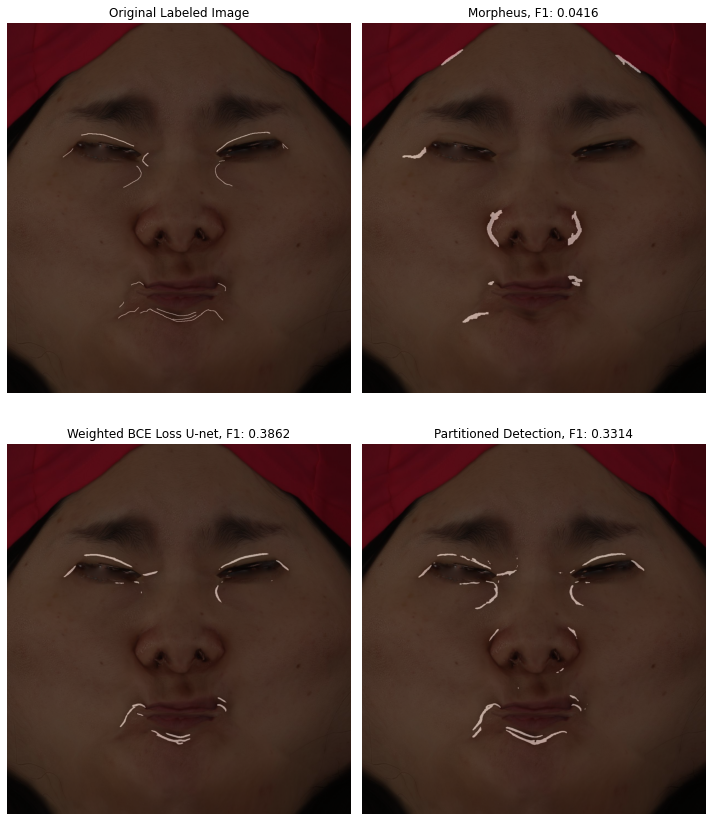

0008_f_25_19_brow_raiser_tex


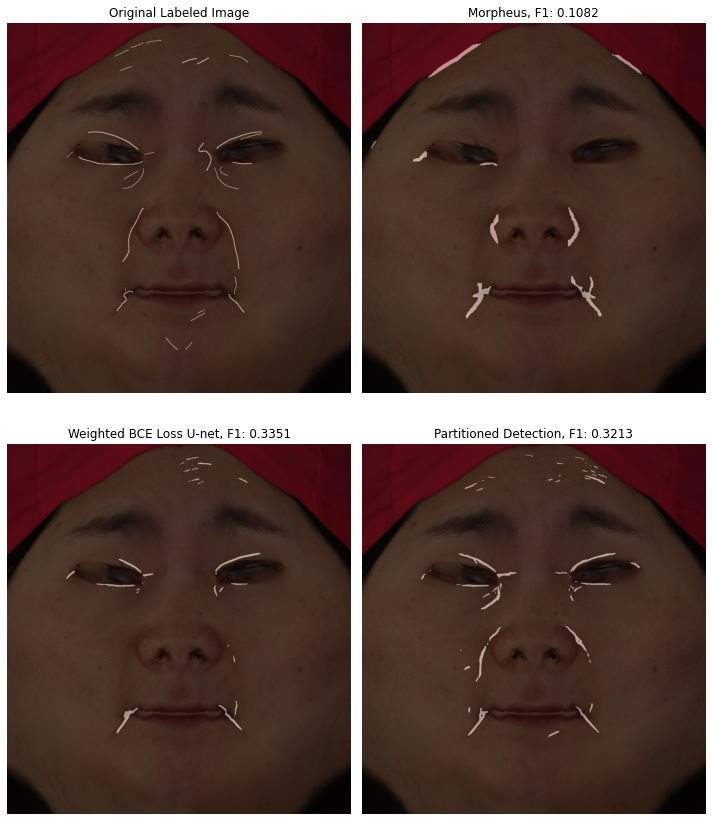

0013_m_20_10_dimpler_tex


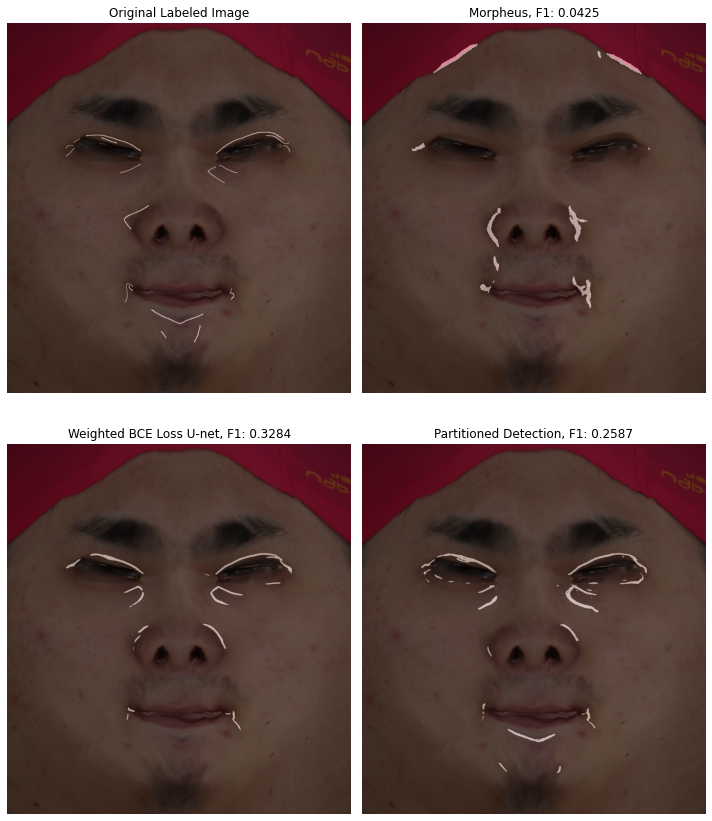

0013_m_20_16_grin_tex


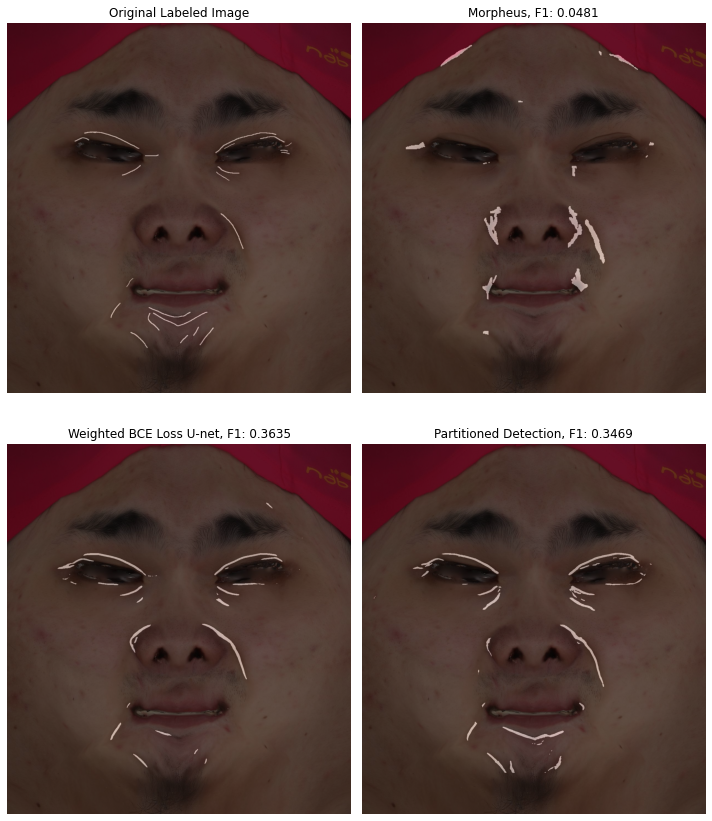

0013_m_20_19_brow_raiser_tex


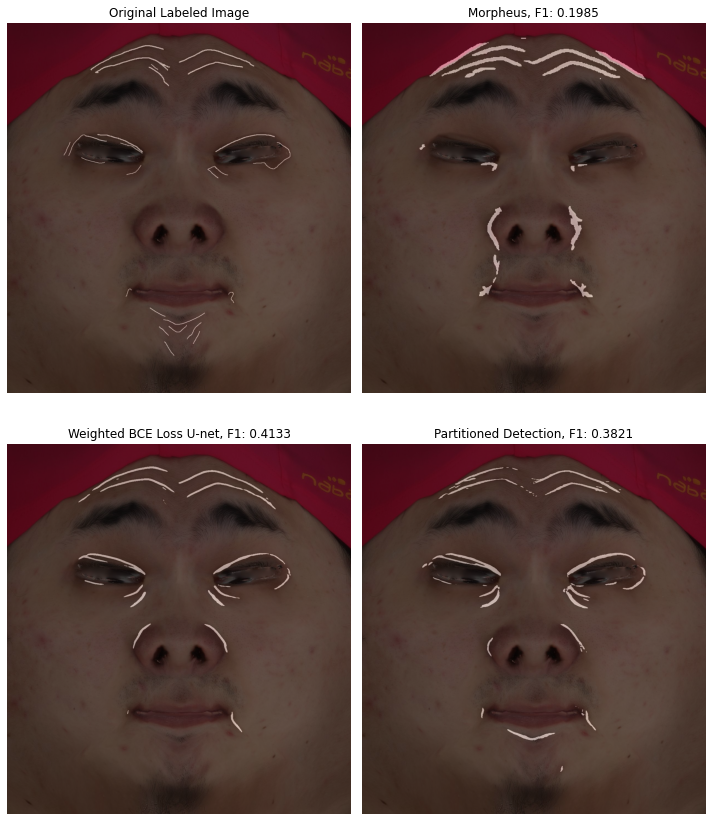

0013_m_20_20_brow_lower_tex


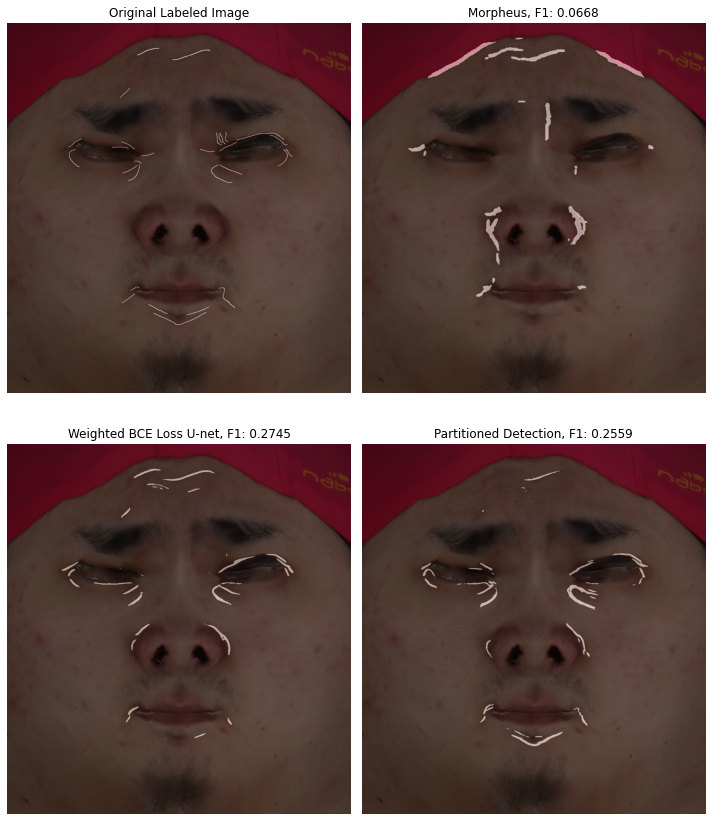

0014_f_58_02_smile_tex


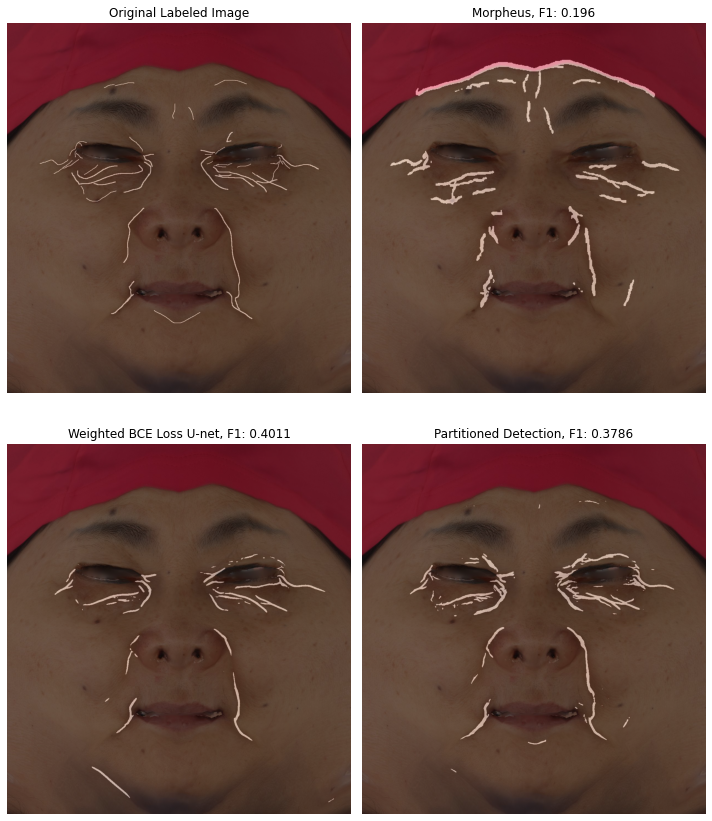

0014_f_58_09_mouth_right_tex


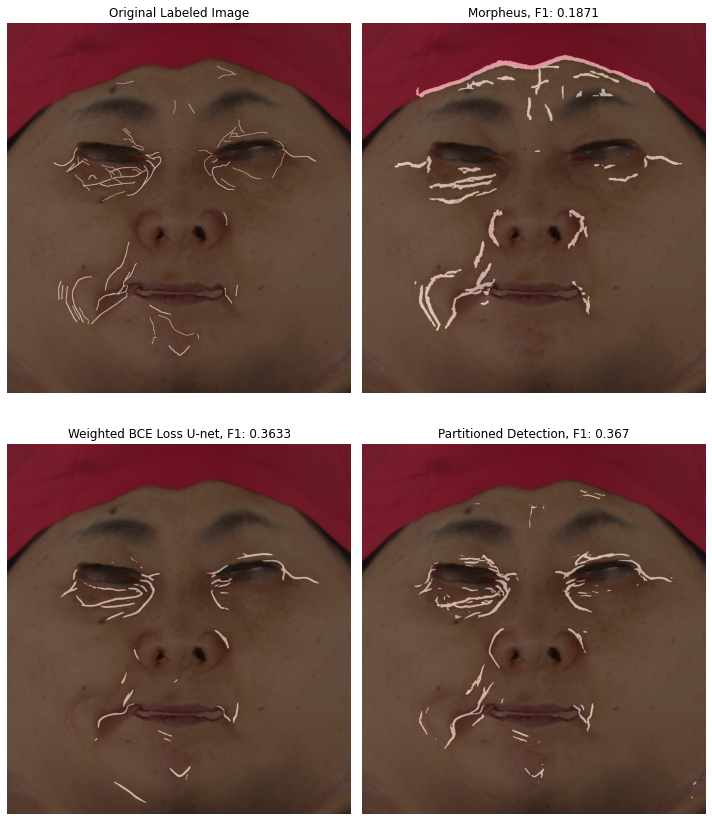

0014_f_58_11_chin_raiser_tex


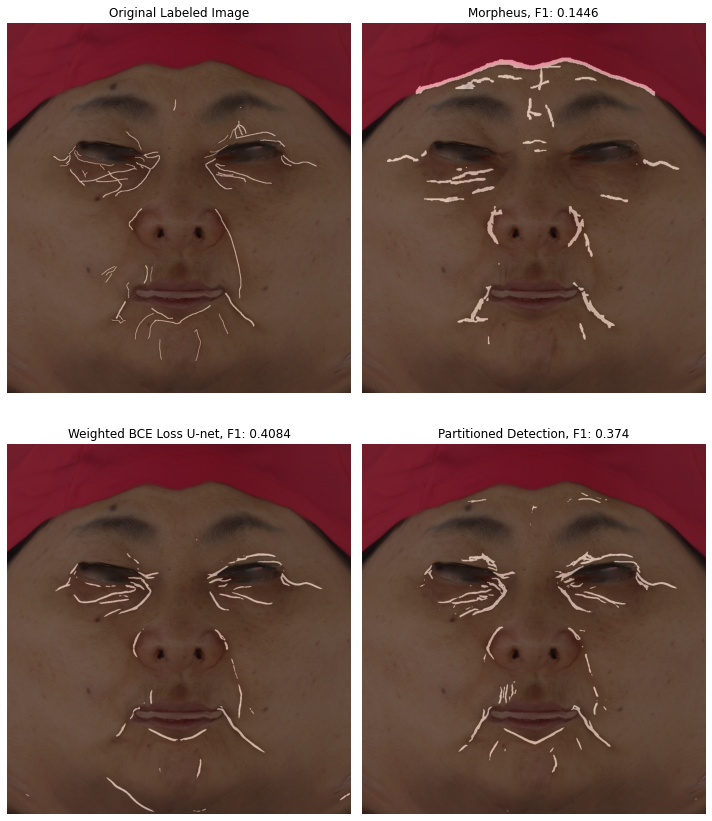

0019_m_20_06_jaw_right_tex


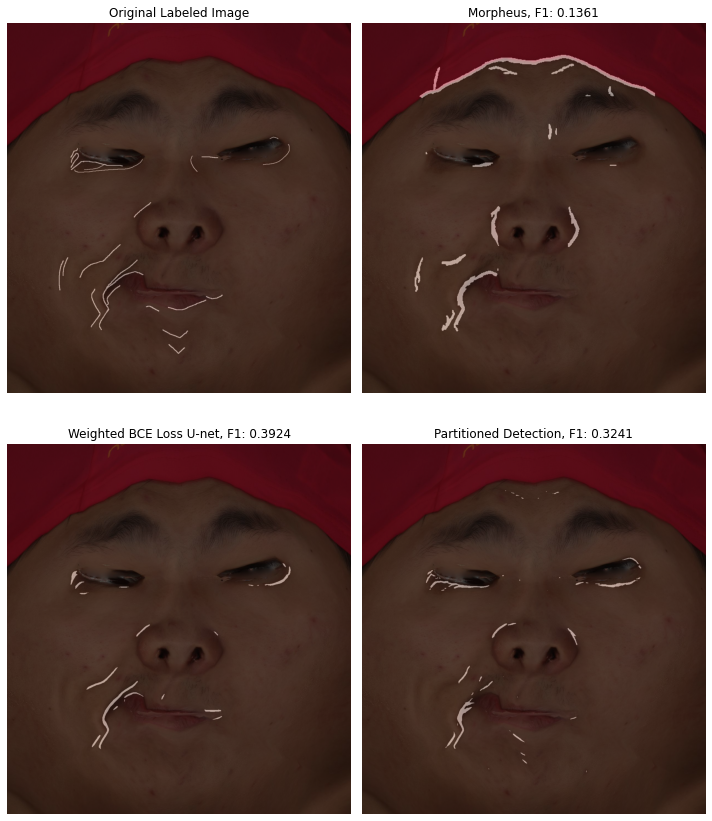

0019_m_20_10_dimpler_tex


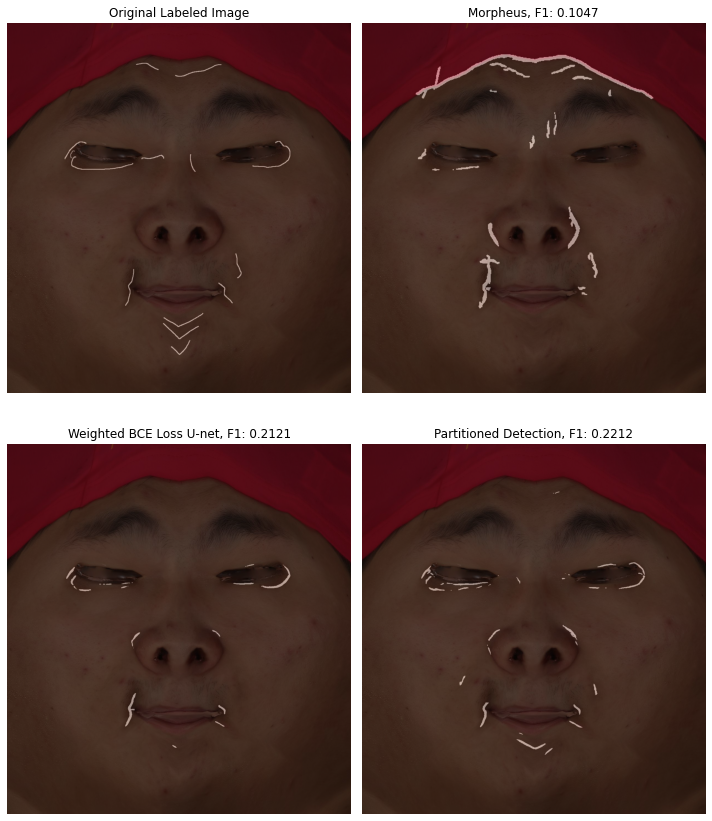

0019_m_20_13_lip_funneler_tex


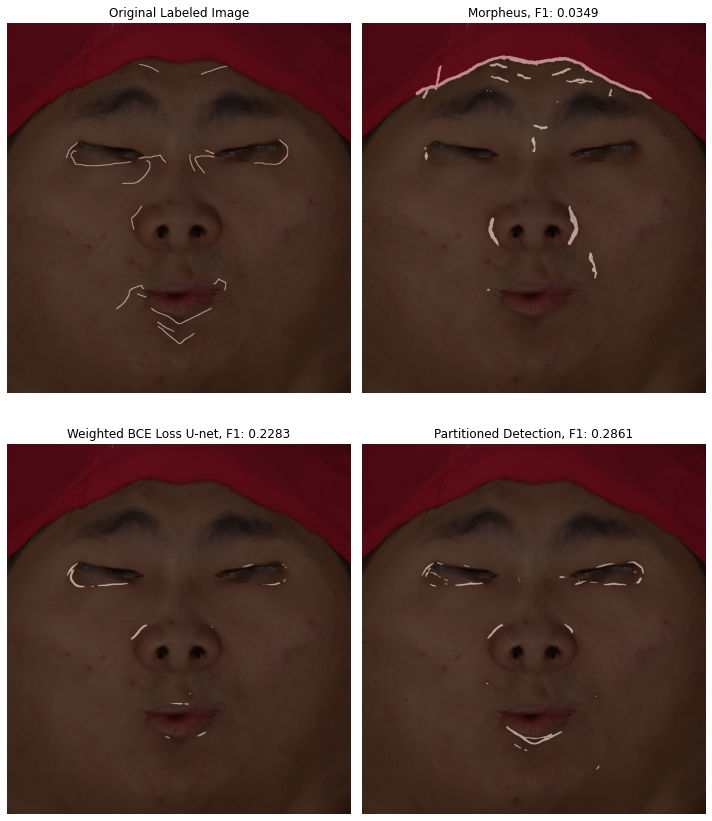

0021_m_27_07_jaw_forward_tex


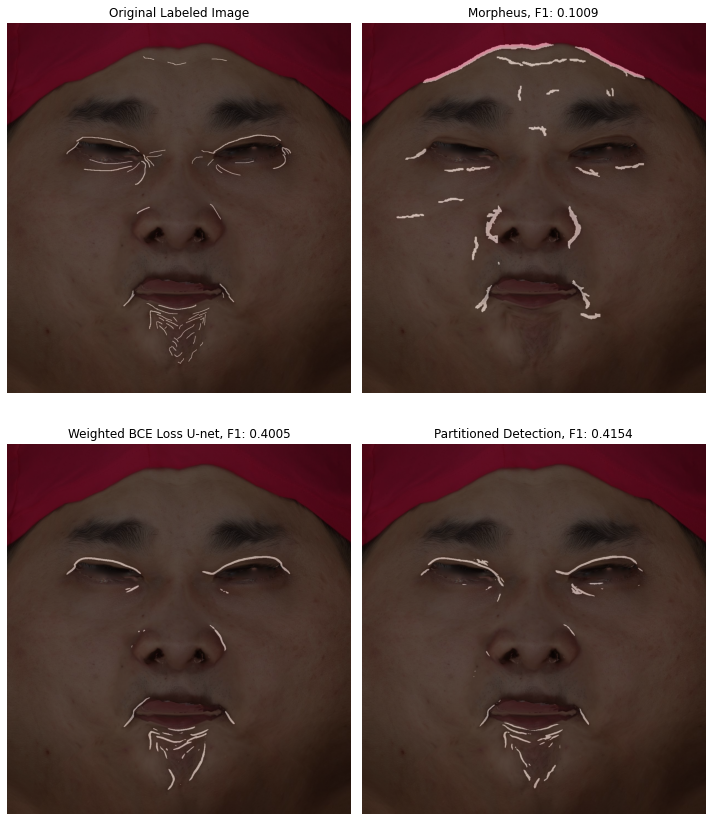

0021_m_27_10_dimpler_tex


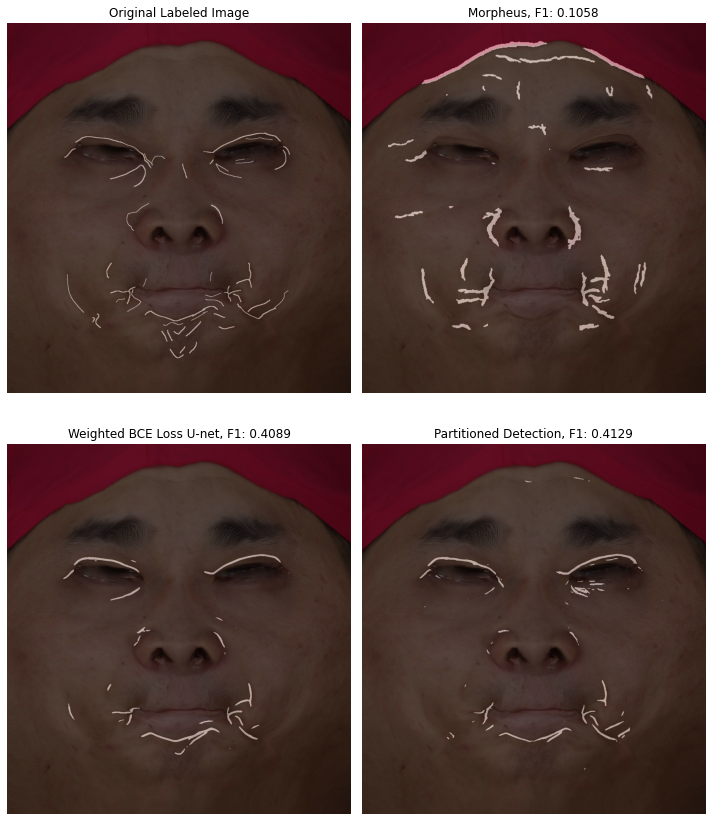

0021_m_27_16_grin_tex


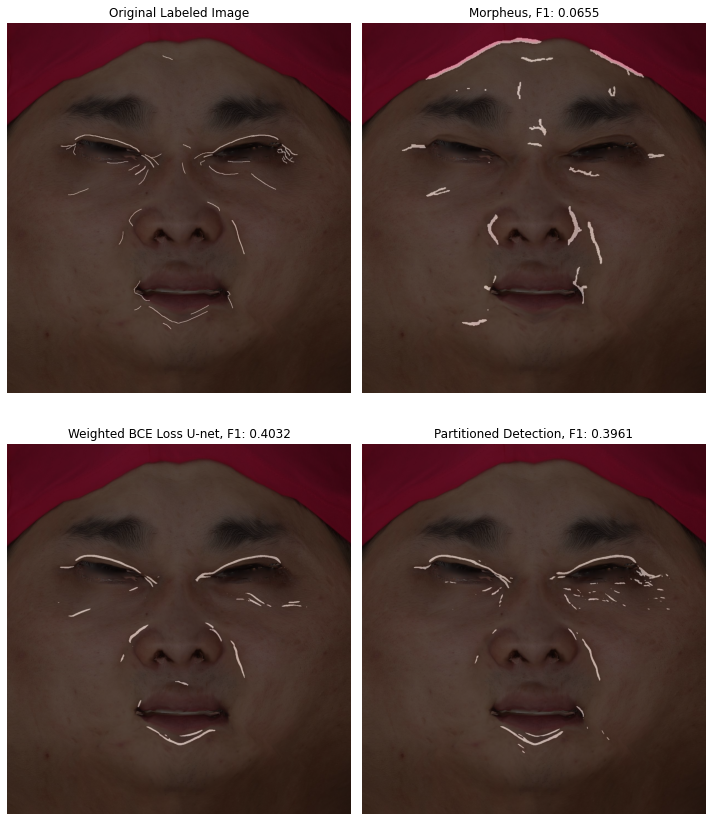

0021_m_27_17_cheek_blowing_tex


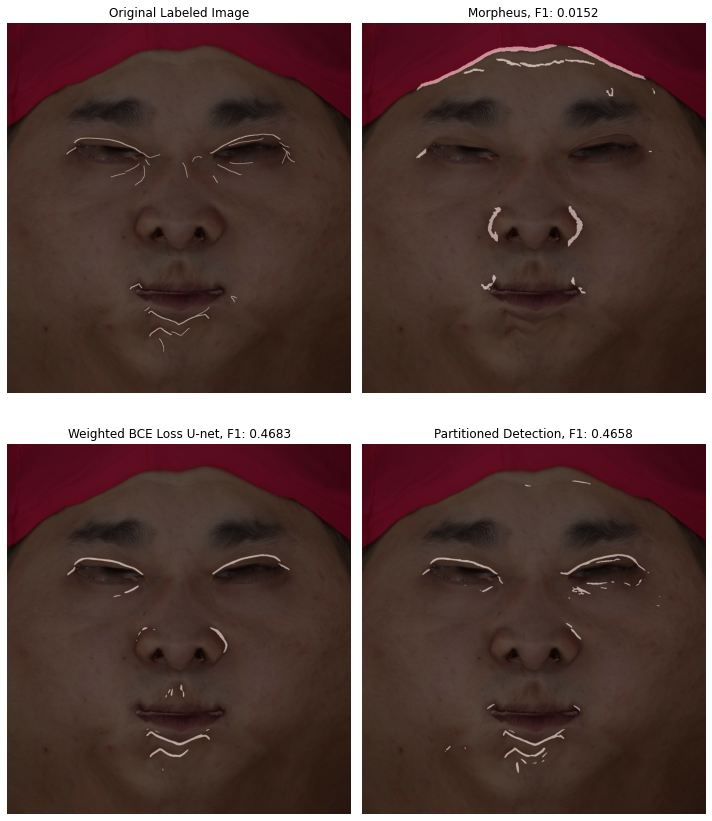

In [16]:
for i in range(image_num):
    label = np.load(os.path.join(orig_data_dir, lable_list[i]))
    morpheus_label = np.load(competitor_dir + lable_list[i])[200:1544, 400:1648]
    baseline_label = np.load(baseline_dir + lable_list[i])
    image = plt.imread(os.path.join(orig_data_dir, image_list[i]))
    # tp, tn, fp, fn, f1
    res_morpheus = f1_score(morpheus_label, label)
    res_baseline = f1_score(baseline_label, label)
    res_wbce = f1_score(wbce_pred_result[i], label)
    
    tp, tn, fp, fn = res_morpheus[:-1]
    morpheus = [(tp+tn)/(tp+fp+tn+fn), tp/(tp+fp), tp/(tp+fn)]
    morpheus.append(2*morpheus[1]*morpheus[2]/(morpheus[1]+morpheus[2]))
    
    tp, tn, fp, fn = res_baseline[:-1]
    baseline = [(tp+tn)/(tp+fp+tn+fn), tp/(tp+fp), tp/(tp+fn)]
    baseline.append(2*baseline[1]*baseline[2]/(baseline[1]+baseline[2]))
    
#     tp, tn, fp, fn = res_wbce[:-1]
#     wbce = [(tp+tn)/(tp+fp+tn+fn), tp/(tp+fp), tp/(tp+fn)]
#     wbce.append(2*wbce[1]*wbce[2]/(wbce[1]+wbce[2]))
    
#     row = list(map(lambda x: format(x, '.4f'), morpheus)) \
#         + list(map(lambda x: format(x, '.4f'), baseline)) \
#         + list(map(lambda x: format(x, '.4f'), wbce))
#     row_str = " ".join(row)
#     print(os.path.splitext(image_list[i])[0] + ' ' + row_str)
    
    f1_morpheus = res_morpheus[4]
    f1_baseline = res_baseline[4]
    f1_wbce = res_wbce[4]
    
    np.ma.masked_where(label > 0, label)
    np.ma.masked_where(morpheus_label > 0, morpheus_label)
    np.ma.masked_where(f1_pred_result[i] > 0, f1_pred_result[i])
    np.ma.masked_where(wbce_pred_result[i] > 0, wbce_pred_result[i])
    
    plt.close()
    fig, axes = plt.subplots(2, 2, figsize=(10, 12))
    axes[0][0].axis('off')
    axes[0][0].set_title("Original Labeled Image")
    axes[0][0].imshow(image)
    axes[0][0].imshow(label, 'gray', alpha=0.5)
    
    axes[0][1].axis('off')
    axes[0][1].set_title(f"Morpheus, F1: {np.round(f1_morpheus, 4)}")
    axes[0][1].imshow(image)
    axes[0][1].imshow(morpheus_label, 'gray', alpha=0.5)
    
    axes[1][0].axis('off')
    axes[1][0].set_title(f"Weighted BCE Loss U-net, F1: {np.round(f1_baseline, 4)}")
    axes[1][0].imshow(image)
    axes[1][0].imshow(baseline_label, 'gray', alpha=0.5)
    
    axes[1][1].axis('off')
    axes[1][1].set_title(f"Partitioned Detection, F1: {np.round(f1_wbce, 4)}")
    axes[1][1].imshow(image)
    axes[1][1].imshow(wbce_pred_result[i], 'gray', alpha=0.5)
    plt.tight_layout()
    plt.savefig(f'../data/competitor/result/00-comparison/{os.path.splitext(lable_list[i])[0]}.jpg', bbox_inches='tight', pad_inches=0, dpi=300)
    print(os.path.splitext(lable_list[i])[0])
    plt.show()
    